# Introduction

This notebook attempts create classification using the SVM classifier. A submission will be made for this model. Additionally the predictions will be combined with the existing predictions in a [VotingClassifier](#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html).

## Summary
* 
*  [results of test AUC](#results-of-test-AUC)
* [finer grid search of the `scale_pos_weight`](#Further-experiments:-finer-grids) shows that 0.1 is still the optimal value

In [39]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from scipy import stats
from joblib import dump
from joblib import load
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import find_dotenv, load_dotenv
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

from src.data.make_dataset import load_sets, save_sets, save_predictions
from src.models.null import NullModel
from src.visualization.visualize import classification_reports, classification_reports_2
from src.visualization.visualize import plot_pie, create_feature_importance_df, plot_feature_importances


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
load_dotenv(find_dotenv())
api = KaggleApi()
api.authenticate()

In [4]:
competition = os.environ['COMPETITION']

# Set up directories

In [5]:
project_dir = Path.cwd().parent.parent
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

# Load data

In [6]:
X_train, X_val, y_train, y_val, X_test = load_sets(interim_data_dir)
X_train_lim, X_val_lim, y_train_lim, y_val_lim, X_test_lim = load_sets(interim_data_dir, suffix='top_8_features')
test_id = pd.read_csv(interim_data_dir / 'test_id.csv')

In [32]:
X = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val])

# Baseline

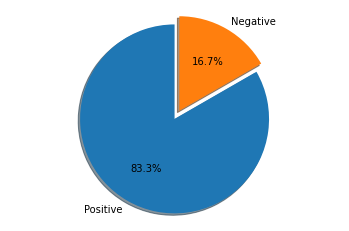

In [7]:
plot_pie(y_train)

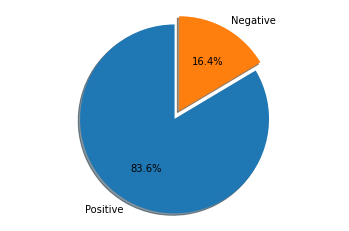

In [8]:
plot_pie(y_val)

## Baseline Score

The baseline is the mode.

In [9]:
null_model = NullModel()

In [11]:
null_model.fit(y_train)

In [13]:
preds = null_model.predict(y_train)
roc_auc_score(y_train, preds)

0.5

# SVM Classifier

In [24]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('classifier', SVC(probability=True))
])
        
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('classifier', SVC(probability=True))])

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[   7 1061]
 [   0 5332]]
Accuracy:  0.83421875
AUC:  0.8357017273981416
              precision    recall  f1-score   support

           0       1.00      0.01      0.01      1068
           1       0.83      1.00      0.91      5332

    accuracy                           0.83      6400
   macro avg       0.92      0.50      0.46      6400
weighted avg       0.86      0.83      0.76      6400



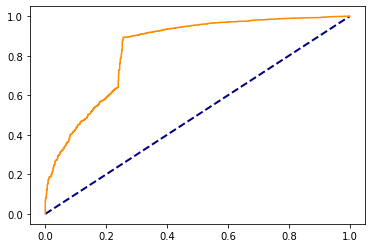

In [25]:
classification_reports(pipe, X_train, y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[   0  263]
 [   0 1337]]
Accuracy:  0.835625
AUC:  0.595931530496458
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       263
           1       0.84      1.00      0.91      1337

    accuracy                           0.84      1600
   macro avg       0.42      0.50      0.46      1600
weighted avg       0.70      0.84      0.76      1600



c:\users\mactuary\.virtualenvs\assignment_1-rwa_wvyq\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mactuary\.virtualenvs\assignment_1-rwa_wvyq\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mactuary\.virtualenvs\assignment_1-rwa_wvyq\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

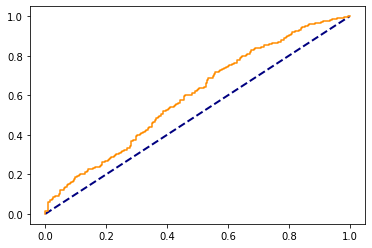

In [26]:
classification_reports(pipe, X_val, y_val)

# Hyperparameter tuning

In [36]:
space = {
    'pca': hp.choice('pca', range(1, 20)),
    'C' : hp.loguniform('C', 0.1, 1000),
    'kernel' : hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']),
    'gamma' : hp.loguniform('gamma', 0.00001, 1),
    'degree' : hp.choice('degree', range(1, 6)),
}

In [41]:
def objective(space):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=space['pca'])),
        ('classifier', SVC(probability=True,
                           C=space['C'],
                           kernel=space['kernel'],
                           gamma=space['gamma'],
                           degree=space['degree']))
    ])
    
    score = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc').mean()
    
    return {'loss': 1-score, 'status': STATUS_OK}

In [ ]:
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=5
)

  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

## Result

This has increased 

## Save model

In [32]:
model_name = ''
models_dir / model_name

WindowsPath('D:/Projects/assignment_1/models/10906675_xgb_es_spw.joblib')

In [33]:
model_name = '.joblib'
dump(grid_cv_fine.best_estimator_, models_dir / model_name)

['D:\\Projects\\assignment_1\\models\\10906675_xgb_es_spw.joblib']

# Prediction on test set

In [34]:
probs = grid_cv_fine.best_estimator_.predict_proba(X_test)[:, 1]

In [35]:
probs

array([0.65319955, 0.65564203, 0.72314936, ..., 0.60709983, 0.72595614,
       0.6344749 ], dtype=float32)

In [36]:
path = processed_data_dir / f'probs_{model_name}.csv'
save_predictions(probs, 'TARGET_5Yrs', test_id, path)

## Submit predictions

# Results of test AUC

The test AUC is .